In [1]:
import os
import glob
import time
from collections import OrderedDict

import cudf
import dask_cuda
import nvtabular as nvt

import graphviz

import numpy as np

DATA_PATH = "./data/"

from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.distributed import wait
from dask.utils import parse_bytes
from dask.delayed import delayed
from nvtabular.utils import device_mem_size, get_rmm_size

cudf.set_allocator(allocator="managed")

In [2]:
cluster = LocalCUDACluster(ip='0.0.0.0',local_directory='/media/rostislav/Ext_SSD/dask')
client = Client(cluster)
client

Client Scheduler: tcp://192.168.0.102:40689 Dashboard: http://192.168.0.102:8787/status,Cluster Workers: 1 Cores: 1 Memory: 31.33 GiB


In [3]:
all_tsv_files = glob.glob(DATA_PATH+"*.tsv")

In [4]:
orig_features = [
    'text_tokens',
    'hashtags',
    'tweet_id',
    'present_media',
    'present_links',
    'present_domains',
    'tweet_type',
    'language',
    'tweet_timestamp',
    'engaged_with_user_id',
    'engaged_with_user_follower_count',
    'engaged_with_user_following_count',
    'engaged_with_user_is_verified',
    'engaged_with_user_account_creation',
    'engaging_user_id',
    'engaging_user_follower_count',
    'engaging_user_following_count',
    'engaging_user_is_verified',
    'engaging_user_account_creation',
    'engagee_follows_engager'
]

orig_dtypes = OrderedDict(
    [
        ('text_tokens','object'),
        ('hashtags','str'),
        ('tweet_id','str'),
        ('present_media','str'),
        ('present_links','str'),
        ('present_domains','str'),
        ('tweet_type','str'),
        ('language','str'),
        ('tweet_timestamp','uint32'),
        ('engaged_with_user_id','str'),
        ('engaged_with_user_follower_count','int64'),
        ('engaged_with_user_following_count','int64'),
        ('engaged_with_user_is_verified','bool'),
        ('engaged_with_user_account_creation','uint32'),
        ('engaging_user_id','str'),
        ('engaging_user_follower_count','int64'),
        ('engaging_user_following_count','int64'),
        ('engaging_user_is_verified','bool'),
        ('engaging_user_account_creation','uint32'),
        ('engagee_follows_engager','bool')
    ]
)

In [5]:
df = cudf.read_csv(DATA_PATH+"part-00000.tsv", sep='\x01', header=0, names=orig_features)

In [6]:
df.head()

,text_tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,engaging_user_id,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engaging_user_account_creation,engagee_follows_engager
0,101\t22800\t11206\t117\t13451\t20517\t25136\t1...,<NA>,2B41BDE7839DE3117D994FDFC9BDA6E1,<NA>,<NA>,<NA>,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1614002023,547810FE65A44B3828FFA4587D1CA0C8,3062,1695,False,1234613277,AE8B92F8CFE9F92C2942DEBBFE4F0FCF,392,487,False,1362687553,True
1,101\t119\t119\t119\t45857\t85270\t10169\t77086...,<NA>,BAF10FE3481E874ED104AC0950F18784,<NA>,<NA>,<NA>,Quote,488B32D24BD4BB44172EB981C1BCA6FA,1612452111,E18710A5B40F9187026AA49A220857BC,2298,346,False,1229141184,ED5574665DB1478CA23F13647178D9BE,1306,5000,False,1244857625,True
2,101\t160\t39187\t10237\t100\t11337\t100\t13028...,<NA>,BCDD3DDDA04C2E7843B3734620EE0C38,Photo,<NA>,<NA>,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1612980390,0CC43EBBB61E292102397B8B08A73DDD,4813450,662,True,1332099335,585F08165162A5C10DE2081ECFACCFC0,90,91,False,1551356429,False
3,101\t56898\t137\t40586\t10305\t53244\t22659\t1...,86458A61FFFA24A5624A9AD8AA2F0F52,43845DCDBC2A2CA15C3B18431F48F1F8,<NA>,<NA>,<NA>,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612834174,29766FB1458BC9BB67EB7E61CBAB957C,2740151,15255,True,1207763634,CAD64086EF823706DEF953E615DB6743,158,411,False,1417656869,False
4,101\t12944\t92188\t88970\t19172\t78467\t10115\...,<NA>,35FC1FC6443CCA260CC5255A8DB86ACB,<NA>,<NA>,<NA>,Quote,1F73BB863A39DB62B4A55B7E558DB1E8,1613649139,6DFE21B7697FE7DB43B043E5A28D272A,1336,2263,False,1528382189,41BD1385BB51D31C6E3D317F7EE3625A,250,807,False,1326053740,True


In [7]:
df['present_media'][df['present_media'].notnull()]

2                               Photo
5                               Photo
9                               Photo
10                       Photo\tPhoto
16                              Photo
                      ...            
3300759    Photo\tPhoto\tPhoto\tPhoto
3300763                         Photo
3300764    Photo\tPhoto\tPhoto\tPhoto
3300766                  Photo\tPhoto
3300767    Photo\tPhoto\tPhoto\tPhoto
Name: present_media, Length: 1259165, dtype: object

In [8]:
df['present_domains'][df['present_domains'].notnull()]

27         F595B7DE8992A3D8C7948B4E81419D78
59         9EFF000CDB18B710CDDB43EE1D8C300B
65         640AE203C40B10669C5F1B741446DEDA
76         B581EB0BB3AC35567F0CC852AD7E6E5C
80         9AD4B0FF899545D4C3033E8F63ED0405
                         ...               
3300705    41BF93F53C6BB22ED806E558536982F4
3300712    545C74C2414BF40FA58A2A8544358D73
3300732    61B36BF6472A84AFB29422E16AF2AE33
3300747    37F6EF8038F7A0B9A07DF964E16EB09A
3300765    F595B7DE8992A3D8C7948B4E81419D78
Name: present_domains, Length: 380381, dtype: object

In [9]:
df['present_links'][df['present_links'].notnull()]

27         83EA4B894C9FB996305B3E2DD48A89E4
59         443ABD366AA35E473CE365B26D57DF66
65         C4BD1D90E9C3143DBDF372215B3CD740
76         2C22BBD7B907543A8E3DAE00F1BBD1AE
80         E4AD3BDD6899E330DF2DBCE61ECF0EEC
                         ...               
3300705    FC2DD5615C085AA63965A2D0FFD7497E
3300712    DF87DC0CDBB778C88201B8E2B83DBF64
3300732    838066DCAF92A21A25E2228C6F5D6CB1
3300747    C7A0B1ACA8B119340249D329738A8D8E
3300765    E88710095B45EC1730C56DAF3A1BF1EB
Name: present_links, Length: 380381, dtype: object

In [10]:
print(df.dtypes)

del df

text_tokens                           object
hashtags                              object
tweet_id                              object
present_media                         object
present_links                         object
present_domains                       object
tweet_type                            object
language                              object
tweet_timestamp                        int64
engaged_with_user_id                  object
engaged_with_user_follower_count       int64
engaged_with_user_following_count      int64
engaged_with_user_is_verified           bool
engaged_with_user_account_creation     int64
engaging_user_id                      object
engaging_user_follower_count           int64
engaging_user_following_count          int64
engaging_user_is_verified               bool
engaging_user_account_creation         int64
engagee_follows_engager                 bool
dtype: object


In [11]:
features_32bit = ['tweet_timestamp', 'engaging_user_following_count', 'engaging_user_follower_count', 'engaged_with_user_follower_count','engaged_with_user_following_count', 'engaging_user_id', 'engaged_with_user_id',
                'engaged_with_user_account_creation', 'engaging_user_account_creation', 'present_links', 'present_media', 'present_domains', 'hashtags', 'tweet_id'] #maxfollowers are in 32bit + 1billion also
features_32bit_dict = {feat:np.uint32 for feat in features_32bit}

features_object = ['text_tokens', 'tweet_type']
features_object_dict = {feat:object for feat in features_object}

features_bool = ['engaged_with_user_is_verified', 'engaging_user_is_verified', 'engagee_follows_engager']
features_bool_dict = {feat:bool for feat in features_bool}

features_16bit = ['tweet_timestamp_wd', 'tweet_timestamp_day', 'tweet_timestamp_month', 'tweet_timestamp_hour', 'language']
features_16bit_dict = {feat:np.uint16 for feat in features_16bit}

# features_64bit = ['present_links', 'present_media', 'present_domains', 'hashtags', 'tweet_id']
# features_64bit_dict = {feat:np.uint64 for feat in features_64bit}

features_dtypes = {**features_16bit_dict, **features_32bit_dict, **features_bool_dict, **features_object_dict}
print(features_dtypes.keys())

dict_keys(['tweet_timestamp_wd', 'tweet_timestamp_day', 'tweet_timestamp_month', 'tweet_timestamp_hour', 'language', 'tweet_timestamp', 'engaging_user_following_count', 'engaging_user_follower_count', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_id', 'engaged_with_user_id', 'engaged_with_user_account_creation', 'engaging_user_account_creation', 'present_links', 'present_media', 'present_domains', 'hashtags', 'tweet_id', 'engaged_with_user_is_verified', 'engaging_user_is_verified', 'engagee_follows_engager', 'text_tokens', 'tweet_type'])


In [12]:
import collections

def splitmedia(col):
    if col.shape[0] == 0:
        return(col)
    else:
        return(col.str.split('\t',expand=True)[0].fillna('') + '_' + col.str.split('\t',expand=True)[1].fillna(''))
    
#split = nvt.ColumnGroup(['present_media']) >> (lambda col: splitmedia(col))

#['hashtags', 'tweet_id', 'language', 'engaging_user_id', 'engaged_with_user_id', 'present_links', 'present_domains'
fill_miss = ['hashtags', 'present_links', 'present_domains','present_media']  >> nvt.ops.FillMissing()

cat_features = (['tweet_id', 'language', 'engaging_user_id', 'engaged_with_user_id'] + fill_miss >> nvt.ops.Categorify())

weekday = (
    nvt.ColumnGroup(['tweet_timestamp']) >>
    (lambda col: cudf.to_datetime(col, unit='s').dt.weekday) >>
    nvt.ops.Rename(postfix = '_wd')
)

day = (
    nvt.ColumnGroup(['tweet_timestamp']) >>
    (lambda col: cudf.to_datetime(col, unit='s').dt.day) >>
    nvt.ops.Rename(postfix = '_day')
)

month = (
    nvt.ColumnGroup(['tweet_timestamp']) >>
    (lambda col: cudf.to_datetime(col, unit='s').dt.month) >>
    nvt.ops.Rename(postfix = '_month')
)

hour = (
    nvt.ColumnGroup(['tweet_timestamp']) >>
    (lambda col: cudf.to_datetime(col, unit='s').dt.hour) >>
    nvt.ops.Rename(postfix = '_hour')
)

remaining_features = [x for x in orig_features if x not in (cat_features+weekday+day+month+hour).columns]

all_features = weekday+day+month+hour+cat_features+remaining_features

print(all_features.columns)
print(collections.Counter(remaining_features+cat_features.columns) == collections.Counter(orig_features))
print(collections.Counter(all_features.columns) == collections.Counter(list(features_dtypes.keys())))

['tweet_timestamp_wd', 'tweet_timestamp_day', 'tweet_timestamp_month', 'tweet_timestamp_hour', 'hashtags', 'present_links', 'present_domains', 'present_media', 'tweet_id', 'language', 'engaging_user_id', 'engaged_with_user_id', 'text_tokens', 'tweet_type', 'tweet_timestamp', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaged_with_user_is_verified', 'engaged_with_user_account_creation', 'engaging_user_follower_count', 'engaging_user_following_count', 'engaging_user_is_verified', 'engaging_user_account_creation', 'engagee_follows_engager']
True
True


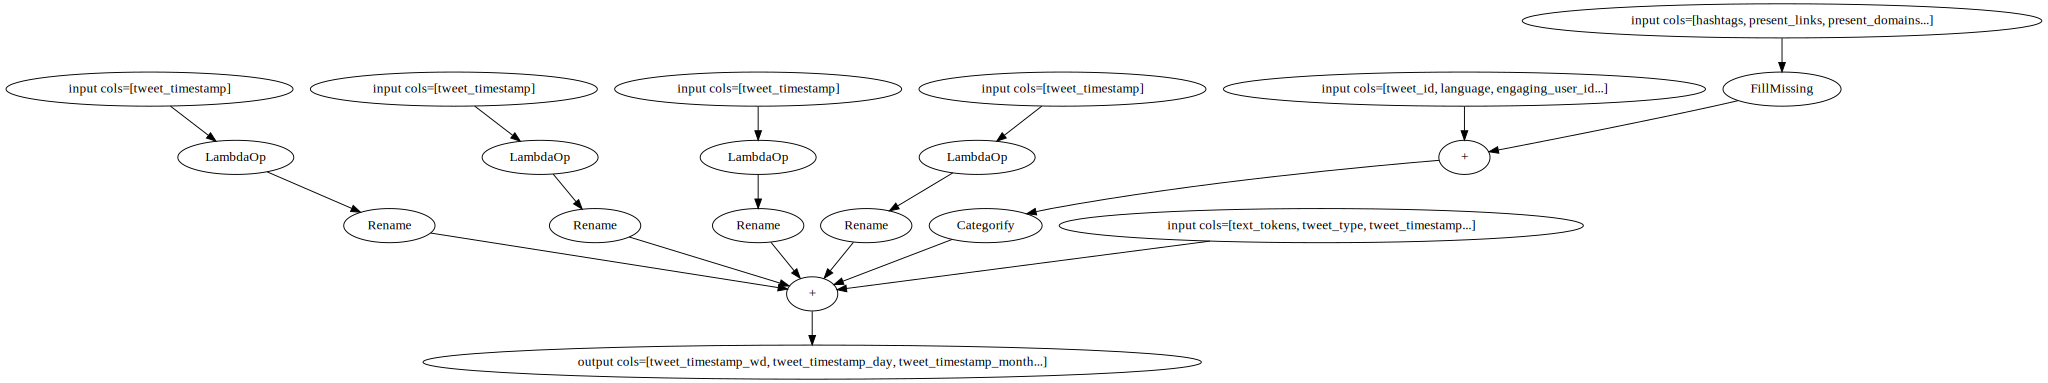

In [13]:
all_features.graph

In [17]:
proc = nvt.Workflow(all_features)
client.run(cudf.set_allocator, "managed")

['tweet_timestamp_wd', 'tweet_timestamp_day', 'tweet_timestamp_month', 'tweet_timestamp_hour', 'hashtags', 'present_links', 'present_domains', 'present_media', 'tweet_id', 'language', 'engaging_user_id', 'engaged_with_user_id', 'text_tokens', 'tweet_type', 'tweet_timestamp', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaged_with_user_is_verified', 'engaged_with_user_account_creation', 'engaging_user_follower_count', 'engaging_user_following_count', 'engaging_user_is_verified', 'engaging_user_account_creation', 'engagee_follows_engager']
None


In [14]:
trains_itrs = nvt.Dataset(all_tsv_files,
                          header=None,
                          names=orig_features,
                          engine='csv',
                          sep='\x01',
                          part_file='1GB',
                          dtypes = orig_dtypes)

In [15]:
%%time

time_preproc_start = time.time()
proc.fit(trains_itrs)
time_preproc = time.time()-time_preproc_start

RuntimeError: cuDF failure at: /opt/conda/envs/rapids/conda-bld/libcudf_1618503955512/work/cpp/src/copying/concatenate.cu:368: Total number of concatenated rows exceeds size_type range

In [16]:
%%time

time_preproc_start = time.time()
proc.transform(trains_itrs).to_parquet(output_path=DATA_PATH + 'preprocess/', preserve_files=True, dtypes=features_dtypes)
time_preproc += time.time()-time_preproc_start

distributed.core - ERROR - Exception while handling op broadcast
Traceback (most recent call last):
  File "/home/rostislav/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/distributed/comm/core.py", line 318, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
  File "/home/rostislav/anaconda3/envs/rapids-0.18/lib/python3.8/asyncio/tasks.py", line 501, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/rostislav/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/distributed/core.py", line 501, in handle_comm
    result = await result
  File "/home/rostislav/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/distributed/scheduler.py", line 5235, in broadcast
    results = await All(
  File "/home/rostislav/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/distributed/utils.py", line 237, in All
  

OSError: Timed out during handshake while connecting to tcp://192.168.0.102:39255 after 10 s

In [17]:
!ls $DATA_PATH/preprocess

In [18]:
test_par = cudf.read_parquet(DATA_PATH+'preprocess/part-00000.tsv.parquet')

FileNotFoundError: [Errno 2] No such file or directory: ['./data/preprocess/part-00000.tsv.parquet']

In [ ]:
test_par.head()

In [ ]:
test_par.dtypes